# Trending Topics Event Study
- How much does going trending increase engagement?

Broadly, the steps:

1. Infer exact time of trending based on trending data
2. RD estimate of causal effect

### Causal Model
Assume that there is no external event triggering engagement. Then, engagement with the hashtag comes from a) exposure to original use before trending and b) exposure through trending topics page 

$Y_{i,t} = \alpha + \lambda_{RD} Trend_{i,t} + \beta_1 Exposed_{i,t} + \beta_2 t $

In [1]:
import preprocessing
from config import TRENDS_DIR
%load_ext autoreload
%autoreload 2
import pandas as pd
import tqdm
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
from config import TWITTER_DATA_DIR
import pickle
import statsmodels.formula.api as smf
import graphviz as gr
import warnings
import numpy as np
warnings.filterwarnings('ignore')

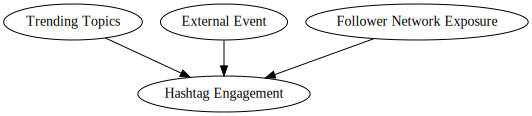

In [221]:
g = gr.Digraph(format='png')
g.edge("Trending Topics", "Hashtag Engagement")
g.edge("External Event", "Hashtag Engagement")
g.edge("Follower Network Exposure", "Hashtag Engagement")
g

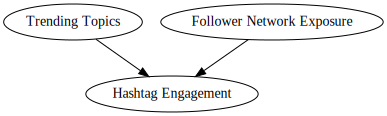

In [222]:
g = gr.Digraph(format='png')
g.edge("Trending Topics", "Hashtag Engagement")
g.edge("Follower Network Exposure", "Hashtag Engagement")
g

In [3]:
def get_trend_behavior(ht):
    '''Takes a hashtag and compiles all trend date about it
    Currently just returns the beginning and end of the trending status, but can do more potentially
    '''
    res = [] 
    for entry in os.scandir(TRENDS_DIR):
        # crude filtering for date csv names 
        if entry.path[-7] == '-':
            df = pd.read_csv(entry, header=None,
                            names=['hashtag', 'place', 
                                   'level', 'day', 
                                   'time', 'volume', 'nan'])
            df['hashtag'] = df.hashtag.apply(lambda x: x.replace('#','').lower())
            try:
                df['datetime'] = pd.to_datetime(df.day + df.time, format='%Y-%m-%d%H:%M')
            except:
                print('error with hashtag', ht)
                return df
            temp = df.query(f'hashtag == "{ht}"')
            if len(temp) > 0:
                res.append(temp)
    if len(res) > 0:
        return pd.concat(res)
    else:
        print(ht, 'did not appear to trend')
        return pd.DataFrame()

In [4]:
campaigns = preprocessing.load_campaign()

In [118]:
hashtag = 'jharkhandwithmodi'
tweets = campaigns[hashtag]

In [6]:
with open(os.path.join(TWITTER_DATA_DIR, 'exposure_results.pkl'), 'rb') as f:
    exposures = pickle.load(f)

In [171]:
def build_df(hashtag, tweet_dict, time_bin='5Min', 
            normalize_time=False):
    # returns timeseries and inferred trending time
    for t_id, tweet in tweet_dict.items():
        tweet['adj_date'] = tweet['date'] + timedelta(hours=5, minutes=30)
        if tweet['retweet_from'] == '':
            if tweet['template'] != '':
                tweet['type'] = 'template'
            else:
                tweet['type'] = 'regular'
        else:
            if tweet['template'] != '':
                tweet['type'] = 'template_retweet'
            else:
                tweet['type'] = 'regular_retweet'
    
        t_exp, n_exp, _ = exposures[hashtag][tweet['username']]
        tweet['template_exposure'] = t_exp
        tweet['normal_exposure'] = n_exp
        tweet['total_exposure'] = t_exp + n_exp
                
    df = pd.DataFrame.from_dict(tweet_dict).transpose()
    df.index = df['adj_date']
        
    trending_data = pd.read_csv(os.path.join(TRENDS_DIR, hashtag+'.csv'), parse_dates=['datetime'])
  
    start = trending_data.datetime.min() + timedelta(hours=5, minutes=30)
    end = trending_data.datetime.max() + timedelta(hours=5, minutes=30)

    min_date = start - timedelta(hours=6)
    max_date = end + timedelta(hours=6)

    colors = ["red","orange",'black','grey']
    types = ['template', 'template_retweet', 'regular', 'regular_retweet']

    series_list = []
    for t in types:
        temp = df[df.type == t] # only use regular tweets
        temp = temp.resample(time_bin).count().username.loc[min_date:max_date]
        series_list.append(temp)
    temp = df[df.type == 'regular'] # only use regular tweets
    series_list.append(temp[temp.total_exposure > 0].resample(time_bin).count().username.loc[min_date:max_date])
    temp = temp[temp.total_exposure == 0].resample(time_bin).count().username.loc[min_date:max_date]
    series_list.append(temp)
    
    new_df = pd.DataFrame(series_list).T
    new_df.columns=[*types, 'zero_exposure_regular', 'nonzero_exposure_regular']
    new_df['total_engagement'] = new_df[types].sum(axis=1)
    new_df['rt_engagement'] = new_df[['regular_retweet', 'template_retweet']].sum(axis=1)
    
    def find_jump(x, start):
        # takes a ts and finds the spike within the start period
        diffed = x.diff()
        for i in range(10):
            candidate = diffed.idxmax()
            if candidate >= start-timedelta(hours=1, minutes=5) and candidate < start:
                return candidate 
            else: # zero out the candidate
                diffed[candidate] = 0
        # no spike found in trending range
        return start - timedelta(hours=1, minutes=5)
    
    exact_trending_loc = find_jump(temp, start)
    
    if normalize_time:
        new_df.index = new_df.index - exact_trending_loc
        new_df.index = new_df.index.map(lambda x: int(x.total_seconds() / 60))
        exact_trending_loc = 0

    new_df['time'] = new_df.index
    new_df['time_i'] = range(len(new_df))
    new_df['time_i2'] = new_df['time_i']*new_df['time_i']

    return new_df, exact_trending_loc

In [8]:
def plot_trending_ts(df, exact_trending_loc, cols=['zero_exposure_regular', 'total_engagement']):
    # takes a df and plots the time series with some acoutrements
    fig = plt.figure(figsize=(14,9))

    trending_data = pd.read_csv(os.path.join(TRENDS_DIR, hashtag+'.csv'), parse_dates=['datetime'])
  
    start = trending_data.datetime.min() + timedelta(hours=5, minutes=30)
    end = trending_data.datetime.max() + timedelta(hours=5, minutes=30)

    min_date = start - timedelta(hours=6)
    max_date = end + timedelta(hours=6)
    for i, col in enumerate(cols):
        ax = plt.subplot(2, 1, i+1)
        temp = df[col]
        ax.scatter(temp.index, temp, label='Zero Exposure Tweets')

        ax.axvline(exact_trending_loc, color='r', ls='--', label='Inferred Trending Time')
        _, max_hist_level = ax.get_ylim()
        ax.plot([start - timedelta(hours=1), start], [max_hist_level*1.1]*2, '|--', color='black', alpha=1, 
                 label='Resolution Error') 
        ax.plot([start, end], [max_hist_level]*2, '-', color='black', alpha=1) 
        ax.plot([start, end], [max_hist_level]*2, '|', color='black') 
        ax.text(start + (end-start)/2, max_hist_level/1.1, f'#{hashtag} trending', fontsize=12, horizontalalignment='center')
        ax.set_xlabel('Time', fontsize=18)
        ax.set_ylabel('Tweet volume', fontsize=16)
        ax.set_title(col)
        import matplotlib.dates as mdates
        hours = mdates.HourLocator() 
        minutes  = mdates.MinuteLocator(byminute=range(0,61,15))
        ax.xaxis.set_major_locator(hours)
        ax.xaxis.set_minor_locator(minutes)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        #ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
        ax.grid(True)
        ax.grid(True, 'minor')
        
        
    fig.autofmt_xdate()
#     handles, labels = plt.gca().get_legend_handles_labels()
#     by_label = dict(zip(labels, handles))
#     plt.legend(by_label.values(), by_label.keys())
#     plt.legend()
    fig.suptitle(f'#{hashtag} Tweets Over Time')
#     plt.tight_layout()    
#     plt.show()

In [50]:
def run_statistics(data, thresh, 
                   model_fit_args=dict(cov_type='HAC',cov_kwds={'maxlags':1})):
    
    results = []
    def simple_table_to_df(tab, prefix):
        df = pd.read_html(tab.as_html(), index_col=0, header=0)[0]
        return pd.concat({prefix: df}, names=['Trial'])
    
    rdd_df = data.assign(threshold=(data.time > thresh).astype(int))
    i_thresh = data.time_i[data.time == thresh].values[0]
    
    # data effects around trending status
    rdd_df = rdd_df.iloc[i_thresh-20:i_thresh+40]
    
    model = smf.wls("regular~time_i*threshold+nonzero_exposure_regular", rdd_df).fit(**model_fit_args)
    results.append(simple_table_to_df(model.summary().tables[1], 'Tweets w/ cov'))

    #     ax = rdd_df.plot.scatter(x="time_i", y="regular", color="C0")
#     rdd_df.assign(predictions=model.fittedvalues).plot(x="time_i", y="predictions", ax=ax, color="C1")
#     plt.title("Regression Discontinuity");

    
    def kernel(R, c, h):
        indicator = (np.abs(R-c) <= h).astype(float)
        return indicator * (1 - np.abs(R-c)/h)

#     model = smf.wls("total_engagement~time_i*threshold", rdd_df,
#                    weights=kernel(data['time_i'], c=i_thresh, h=18)).fit(**model_fit_args)
#     results.append(simple_table_to_df(model.summary().tables[1], 'Weighted Total Engagement'))
    
    model = smf.wls("regular~time_i*threshold", rdd_df).fit(**model_fit_args)
    results.append(simple_table_to_df(model.summary().tables[1], 'Tweets'))
    
    model = smf.wls("total_engagement~time_i*threshold", rdd_df).fit(**model_fit_args)
    results.append(simple_table_to_df(model.summary().tables[1], 'Total Engagement'))
    
    model = smf.wls("zero_exposure_regular~time_i*threshold", rdd_df).fit(**model_fit_args)
    results.append(simple_table_to_df(model.summary().tables[1], 'Zero Exposure Tweets'))
    
    res_df = pd.concat(results)
    def highlight_significant(s):
        res = 'background-color: yellow' if s.z >= 1.96 else ''
        return [res for x in s] 
    display(res_df.style.apply(highlight_significant, axis=1))
    return res_df

In [229]:
def run_statistics_2(data, thresh, 
                   model_fit_args=dict(cov_type='HAC',cov_kwds={'maxlags':1})):
    
    def simple_table_to_df(tab, prefix):
        df = pd.read_html(tab.as_html(), index_col=0, header=0)[0]
        return pd.concat({prefix: df}, names=['Trial'])
    
    rdd_df = data.assign(threshold=(data.time > thresh).astype(int))
    i_thresh = data.time_i[data.time == thresh].values[0]
    
    # data effects around trending status
    rdd_df = rdd_df.iloc[i_thresh-12:i_thresh+12]
    
    model = smf.wls("regular~time_i*threshold+nonzero_exposure_regular", rdd_df).fit(**model_fit_args)
    res_df = simple_table_to_df(model.summary().tables[1], 'New Tweets')
    def highlight_significant(s):
        res = 'background-color: yellow' if s.z >= 1.96 else ''
        return [res for x in s] 

    display(res_df.style.apply(highlight_significant, axis=1))
    return res_df

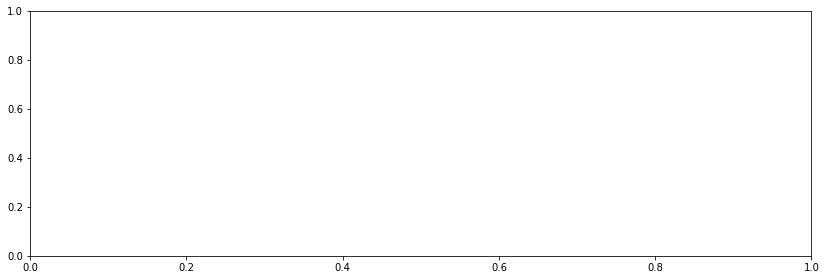

In [51]:
res = run_statistics(*build_df(hashtag, tweets))

In [230]:
meta_res = []
for hashtag, tweet_dict in campaigns.items():
    try:
        res = run_statistics_2(*build_df(hashtag, tweet_dict))
        meta_res.append(pd.concat({hashtag: res}, names=['Hashtag']))
    except: 
        print(hashtag, ' did not work')

timesofrahul  did not work
threadsofexcellence  did not work
msmetextilesconclave  did not work


म्हारा_वोट_भाजपा_को  did not work


congressinsultsairforce  did not work


bogibeelbridge  did not work


congressdefencescams  did not work
hooghly_chalo  did not work


goodgovernanceday  did not work


namowithtraders  did not work


indiabolemodidobara  did not work


zamanatke1000din  did not work


congressframedamitshah  did not work
mainbhichowkidar  did not work


congressagainstnationalsecurity  did not work
आदर्शघोटाला_संघर्ष_यात्रा  did not work


bjpforsamridhkisan  did not work


rahulkidefencedeals  did not work
rahulgandhijavabdo  did not work


bjpvijaysankalpbikerally  did not work
successofmakeinindia  did not work
pmkisan  did not work
congresseurofighterscandal  did not work


takingforwardhinducause  did not work


bjpkamaljyoti  did not work


removetraitorsfromdu  did not work
modiagain2019  did not work


armedforcesflagday  did not work
nris4modi  did not work
modifiedtextiles  did not work


modifiedjobs  did not work


In [233]:
df

coef  std err  \
Hashtag           Trial                                                   
jharkhandwithmodi New Tweets Intercept                -17.5327    8.650   
                             time_i                     0.3498    0.171   
                             threshold                 58.6940   26.296   
                             time_i:threshold          -0.8725    0.421   
                             nonzero_exposure_regular   1.0510    0.201   
...                                                        ...      ...   
gappupappu        New Tweets Intercept                 14.6069    6.941   
                             time_i                    -0.1547    0.141   
                             threshold                -35.3187    9.420   
                             time_i:threshold           0.5538    0.170   
                             nonzero_exposure_regular   0.6496    0.470   

                                                           z  P>|z|  [0.025  \
Hashtag           Trial                                                       
jharkhandwithmodi New Tweets Intercept                -2.027  0.043 -34.486   
                             time_i                    2.042  0.041   0.014   
                             threshold                 2.232  0.026   7.154   
                             time_i:threshold         -2.074  0.038  -1.697   
                             nonzero_exposure_regular  5.219  0.000   0.656   
...                                                      ...    ...     ...   
gappupappu        New Tweets Intercept                 2.104  0.035   1.002   
                             time_i                   -1.099  0.272  -0.431   
                             threshold                -3.749  0.000 -53.781   
                             time_i:threshold          3.260  0.001   0.221   
                             nonzero_exposure_regular  1.381  0.167  -0.272   

                                                        0.975]       Trial  \
Hashtag           Trial                                                      
jharkhandwithmodi New Tweets Intercept                  -0.579  New Tweets   
                             time_i                      0.685  New Tweets   
                             threshold                 110.234  New Tweets   
                             time_i:threshold           -0.048  New Tweets   
                             nonzero_exposure_regular    1.446  New Tweets   
...                                                        ...         ...   
gappupappu        New Tweets Intercept                  28.212  New Tweets   
                             time_i                      0.121  New Tweets   
                             threshold                 -16.856  New Tweets   
                             time_i:threshold            0.887  New Tweets   
                             nonzero_exposure_regular    1.571  New Tweets   

                                                                       Variable  \
Hashtag           Trial                                                           
jharkhandwithmodi New Tweets Intercept                                Intercept   
                             time_i                                      time_i   
                             threshold                                threshold   
                             time_i:threshold                  time_i:threshold   
                             nonzero_exposure_regular  nonzero_exposure_regular   
...                                                                         ...   
gappupappu        New Tweets Intercept                                Intercept   
                             time_i                                      time_i   
                             threshold                                threshold   
                             time_i:threshold                  time_i:threshold   
                             nonzero_exposu

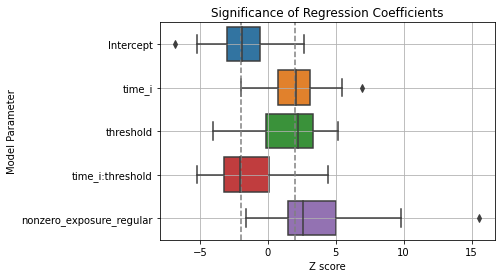

In [243]:
df = pd.concat(meta_res)
df['Trial'] = df.index.get_level_values(1)
df['Variable'] = df.index.get_level_values(2)
df['Hashtag'] = df.index.get_level_values(0)

sns.boxplot(x='z', y='Variable', data=df)
plt.grid(True)
plt.title('Significance of Regression Coefficients')
plt.xlabel('Z score')
plt.ylabel('Model Parameter')
plt.axvline(2, color='grey', ls='--')
plt.axvline(-2, color='grey', ls='--')

Text(0, 0.5, 'Model Parameter')

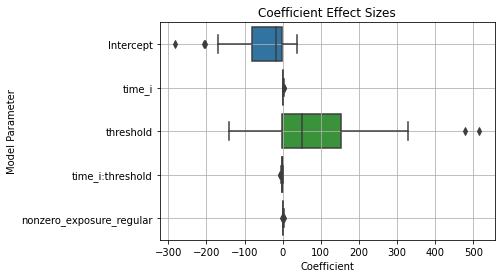

In [245]:
df = pd.concat(meta_res)
df['Trial'] = df.index.get_level_values(1)
df['Variable'] = df.index.get_level_values(2)
df['Hashtag'] = df.index.get_level_values(0)

sns.boxplot(x='coef', y='Variable', data=df)
plt.grid(True)
plt.title('Coefficient Effect Sizes')
plt.xlabel('Coefficient')
plt.ylabel('Model Parameter')

In [94]:
import seaborn as sns

In [113]:
def meta_analysis(df):
    idx = pd.IndexSlice
    df['Trial'] = df.index.get_level_values(1)
    df['Variable'] = df.index.get_level_values(2)
    df['Hashtag'] = df.index.get_level_values(0)
    
    temp = df.loc[idx[:, :, ['threshold']], :] # ['threshold']], :]
    sns.boxplot(x='coef', y='Trial', data=temp)
    plt.grid(True)
    plt.title('Trending Topics Effect Size')
    plt.xlabel('Coefficient')
    plt.ylabel('Model')

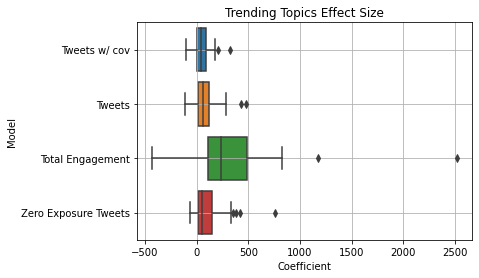

In [114]:
meta_analysis(pd.concat(meta_res))

## TODO
- analyze entire panel
- add logs
- sensitivity to bin size
- 

## Combining All Hashtags and Normalizing Time

$Y_{iht} = \gamma_{h} + \lambda_t + \beta D_{ht} + \epsilon_{iht}$

In [180]:
dfs = []
for hashtag, tweet_dict in campaigns.items():
    try:
        temp, _ = build_df(hashtag, tweet_dict, normalize_time=True)
        temp = temp.assign(threshold=(temp.time > 0).astype(int))
        temp['hashtag'] = hashtag
        dfs.append(temp)
    except Exception as e:
        print(hashtag, 'did not work')
        
panel_df = pd.concat(dfs)
panel_df

bogibeelbridge did not work
hooghly_chalo did not work
goodgovernanceday did not work
congressframedamitshah did not work
mainbhichowkidar did not work
congressagainstnationalsecurity did not work
bjpvijaysankalpbikerally did not work
bjpkamaljyoti did not work
modiagain2019 did not work
armedforcesflagday did not work
nris4modi did not work


In [201]:
query.hashtag = pd.Categorical(query.hashtag).codes

In [199]:
pd.get_dummies(query,'hashtag')

,template,template_retweet,regular,regular_retweet,zero_exposure_regular,nonzero_exposure_regular,total_engagement,rt_engagement,time,time_i,...,hashtag_threadsofexcellence,hashtag_timesofrahul,hashtag_urban_नक्सली_केजरीवाल,hashtag_yuvakemannkibaat,hashtag_zamanatke1000din,hashtag_आदर्शघोटाला_संघर्ष_यात्रा,hashtag_उत्तरप्रदेश_विजय_संकल्प,hashtag_भारत_माता_की_जय,hashtag_म्हारा_वोट_भाजपा_को,hashtag_लक्ष्य_हमारा_मोदी_दोबारा
adj_date,,,,,,,,,,,,,,,,,,,,,
-55,4.0,NaN,1.0,0.0,0.0,1.0,5.0,0.0,-55,48,...,0,0,0,0,0,0,0,0,0,0
-50,1.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,-50,49,...,0,0,0,0,0,0,0,0,0,0
-45,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-45,50,...,0,0,0,0,0,0,0,0,0,0
-40,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-40,51,...,0,0,0,0,0,0,0,0,0,0
-35,0.0,NaN,1.0,0.0,0.0,1.0,1.0,0.0,-35,52,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.0,0.0,8.0,18.0,8.0,0.0,26.0,18.0,75,74,...,0,0,0,0,0,0,0,0,0,0
80,0.0,0.0,13.0,13.0,13.0,0.0,26.0,13.0,80,75,...,0,0,0,0,0,0,0,0,0,0
85,0.0,0.0,7.0,9.0,6.0,1.0,16.0,9.0,85,76,...,0,0,0,0,0,0,0,0,0,0


In [215]:
64*30

1920

In [213]:
len(panel_df.hashtag.unique())

64

In [209]:
panel_df.query('time > -60 & time < 100').fillna(0)

,template,template_retweet,regular,regular_retweet,zero_exposure_regular,nonzero_exposure_regular,total_engagement,rt_engagement,time,time_i,time_i2,threshold,hashtag
adj_date,,,,,,,,,,,,,
-55,4.0,0.0,1.0,0.0,0.0,1.0,5.0,0.0,-55,48,2304,0,jharkhandwithmodi
-50,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-50,49,2401,0,jharkhandwithmodi
-45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-45,50,2500,0,jharkhandwithmodi
-40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-40,51,2601,0,jharkhandwithmodi
-35,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,-35,52,2704,0,jharkhandwithmodi
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.0,0.0,8.0,18.0,8.0,0.0,26.0,18.0,75,74,5476,1,gappupappu
80,0.0,0.0,13.0,13.0,13.0,0.0,26.0,13.0,80,75,5625,1,gappupappu
85,0.0,0.0,7.0,9.0,6.0,1.0,16.0,9.0,85,76,5776,1,gappupappu


In [251]:
query = panel_df.query('time > -60 & time < 60').fillna(0)
# convert hashtags to numeric
query.hashtag = pd.Categorical(query.hashtag).codes
query = query.dropna()
mod = smf.ols("regular ~ time*threshold + C(hashtag) + nonzero_exposure_regular", data=query).fit(cov_type='cluster', cov_kwds={'groups': query['hashtag']} )
temp_df = pd.read_html(mod.summary().tables[1].as_html(), index_col=0, header=0)[0]
temp_df.loc[~temp_df.index.str.startswith('C', na=False)]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.4053,1.909,0.212,0.832,-3.336,4.147
time,0.1209,0.039,3.062,0.002,0.044,0.198
threshold,4.0796,1.840,2.217,0.027,0.473,7.686
time:threshold,-0.1522,0.064,-2.384,0.017,-0.277,-0.027
nonzero_exposure_regular,2.5394,0.444,5.713,0.000,1.668,3.410


In [246]:
panel_df

,template,template_retweet,regular,regular_retweet,zero_exposure_regular,nonzero_exposure_regular,total_engagement,rt_engagement,time,time_i,time_i2,threshold,hashtag
adj_date,,,,,,,,,,,,,
-295,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,-295,0,0,0,jharkhandwithmodi
-290,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,-290,1,1,0,jharkhandwithmodi
-285,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,-285,2,4,0,jharkhandwithmodi
-280,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,-280,3,9,0,jharkhandwithmodi
-275,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,-275,4,16,0,jharkhandwithmodi
...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,NaN,0.0,1.0,6.0,1.0,0.0,7.0,6.0,945,248,61504,1,gappupappu
950,NaN,0.0,4.0,3.0,3.0,1.0,7.0,3.0,950,249,62001,1,gappupappu
955,NaN,0.0,1.0,2.0,1.0,0.0,3.0,2.0,955,250,62500,1,gappupappu


In [ ]:
query = panel_df.query('time > -60 & time < 60').fillna(0)
# convert hashtags to numeric
query.hashtag = pd.Categorical(query.hashtag).codes
query = query.dropna()
mod = smf.ols("regular ~ time*threshold + C(hashtag) + nonzero_exposure_regular", data=query).fit(cov_type='cluster', cov_kwds={'groups': query['hashtag']} )
mod.summary()

In [218]:
query = panel_df.query('time > -60 & time < 60').fillna(0)
# convert hashtags to numeric
query.hashtag = pd.Categorical(query.hashtag).codes
query = query.dropna()
mod = smf.ols("regular ~ time*threshold + C(hashtag) + nonzero_exposure_regular", data=query).fit(
    cov_type='HAC',cov_kwds={'maxlags':1})
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                regular   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     22.27
Date:                Mon, 11 Jan 2021   Prob (F-statistic):          7.88e-169
Time:                        15:15:55   Log-Likelihood:                -5188.5
No. Observations:                1347   AIC:                         1.051e+04
Df Residuals:                    1279   BIC:                         1.087e+04
Df Model:                          67                                         
Covariance Type:                  HAC                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.4053      1.445      0.280      0.779      -2.427       3.238
C(hashtag)[T.1]             11.3350      2.582      4.391      0.000       6.275      16.395
C(hashtag)[T.2]              2.0640      1.346      1.533      0.125      -0.575       4.703
C(hashtag)[T.3]              1.5154      1.639      0.924      0.355      -1.698       4.729
C(hashtag)[T.4]             28.6981      4.504      6.371      0.000      19.870      37.526
C(hashtag)[T.5]              7.2965      1.819      4.011      0.000       3.731      10.862
C(hashtag)[T.6]              0.0948      1.481      0.064      0.949      -2.808       2.998
C(hashtag)[T.7]              1.9834      1.603      1.237      0.216      -1.159       5.126
C(hashtag)[T.8]              5.6624      1.629      3.476      0.001       2.469       8.855
C(hashtag)[T.9]             -1.1223      1.831     -0.613      0.540      -4.711       2.466
C(hashtag)[T.10]            -0.6327      1.822     -0.347      0.728      -4.204       2.938
C(hashtag)[T.11]            -3.4677      1.281     -2.706      0.007      -5.979      -0.956
C(hashtag)[T.12]            -1.1939      1.464     -0.816      0.415      -4.063       1.675
C(hashtag)[T.13]             6.9267      1.968      3.520      0.000       3.069      10.784
C(hashtag)[T.14]            -3.1721      4.231     -0.750      0.453     -11.464       5.120
C(hashtag)[T.15]             0.1178      1.569      0.075      0.940      -2.957       3.192
C(hashtag)[T.16]             4.4699      2.073      2.156      0.031       0.406       8.534
C(hashtag)[T.17]             3.4553      1.681      2.055      0.040       0.160       6.750
C(hashtag)[T.18]             7.4026      1.620      4.570      0.000       4.228      10.577
C(hashtag)[T.19]             0.1612      1.705      0.095      0.925      -3.181       3.504
C(hashtag)[T.20]            19.2375      6.740      2.854      0.004       6.028      32.447
C(hashtag)[T.21]             4.3747      2.096      2.088      0.037       0.268       8.482
C(hashtag)[T.22]            17.3390      3.314      5.231      0.000      10.843      23.835
C(hashtag)[T.23]             1.4382      1.670      0.861      0.389      -1.835       4.711
C(hashtag)[T.24]             2.4255      1.481      1.638      0.101      -0.477       5.328
C(hashtag)[T.25]             5.6599      2.767      2.046      0.041       0.237      11.083
C(hashtag)[T.26]            13.7801      3.660      3.765      0.000       6.606      20.954
C(hashtag)[T.27]             0.5726      1.353      0.423      0.672      -2.079       3.224
C(hashtag)[T.28]            22.0277      4.550      4.841      0.000      13.110      30.946
C(hashtag)[T.29]            -0.0420      1.485     -0.028      0.977      -2.952       2.869
C(hashtag)[T.3

In [117]:
len(exposures.keys())

68

In [131]:
x.columns

Index(['template', 'template_retweet', 'regular', 'regular_retweet',
       'zero_exposure_regular', 'nonzero_exposure_regular', 'time', 'time_i',
       'time_i2', 'total_engagement', 'rt_engagement'],
      dtype='object')

In [163]:
def plot_all_event_study(quantiles=(.1,.99), time_bin='5Min'):
    # plot everything
    fig, axs = plt.subplots(2, 1, figsize=(14,9))
    for hashtag, tweet_dict in campaigns.items():
        try:
            temp, _ = build_df(hashtag, tweet_dict, normalize_time=True)
            axs[0].plot(temp.index, temp.zero_exposure_regular,
                    alpha=.4)
            axs[1].plot(temp.index, temp.total_engagement, alpha=.4)

        except Exception as e:
            print(hashtag, 'did not work')
            print(e)

    axs[1].set_xlabel('Minutes Since Trending', fontsize=18)
    axs[0].set_ylabel('Tweet volume', fontsize=16)
    axs[1].set_ylabel('Tweet volume', fontsize=16)
    axs[0].set_xlim(-100, 200)
    axs[1].set_xlim(-100, 200)
    axs[0].set_title('Zero Exposure Tweets')
    axs[1].set_title('Total Engagement')
    axs[0].grid()
    axs[1].grid()

bogibeelbridge did not work
'bogibeelbridge'
hooghly_chalo did not work
'datetime' is not in list
goodgovernanceday did not work
'goodgovernanceday'
congressframedamitshah did not work
'datetime' is not in list
mainbhichowkidar did not work
'mainbhichowkidar'
congressagainstnationalsecurity did not work
'datetime' is not in list
bjpvijaysankalpbikerally did not work
'bjpvijaysankalpbikerally'
bjpkamaljyoti did not work
'bjpkamaljyoti'
modiagain2019 did not work
'modiagain2019'
armedforcesflagday did not work
'armedforcesflagday'
nris4modi did not work
'datetime' is not in list


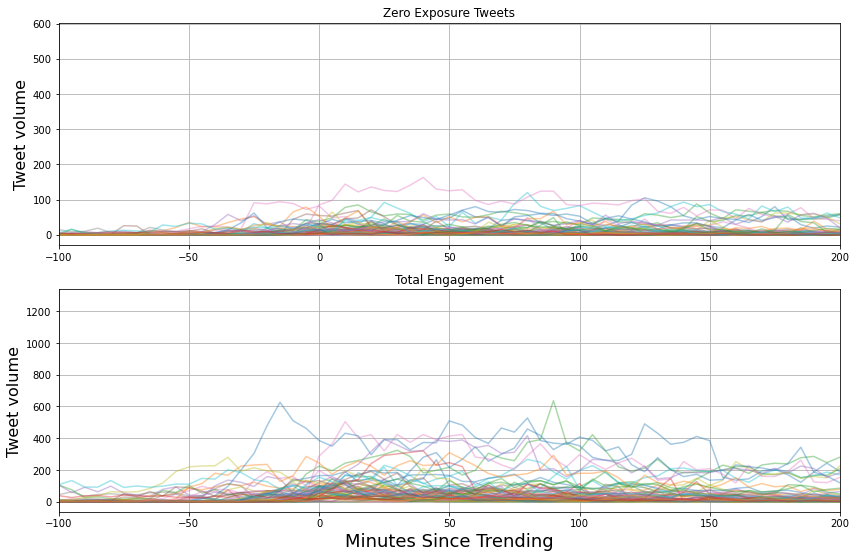

In [164]:
plot_all_event_study()

In [34]:
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge jinja2

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /home/jschless/.conda/envs/gt:

The following NEW packages will be INSTALLED:

    jinja2:     2.11.2-pyh9f0ad1d_0  conda-forge
    markupsafe: 1.1.1-py38h497a2fe_3 conda-forge

markupsafe-1.1 100% |################################| Time: 0:00:00 139.12 kB/s
jinja2-2.11.2- 100% |################################| Time: 0:00:00  19.24 MB/s
